In [1]:
pwd

'c:\\Users\\justi\\Google 드라이브\\Colab Notebooks'

# PUBG 최종 생존 예측 ML/NN 모델

### (주의 1.)본 커널은 이상치(핵 사용 유저)를 제거하여 분석한다.
### (주의 2.)핵쟁이를 제외 하지 않은 분석도 제작 예정이다. 
현실 게임에서는 항상 어느 정도 핵이 존재한다. 그러나 우리는 순수한 실력으로 우열을 가린다.


#Package Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc, sys
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras import optimizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# 데이터 불러오기

데이터 출처: [Kaggle](https://www.kaggle.com/c/pubg-finish-placement-prediction/data)

In [2]:
cd /content/drive/My Drive/data/pubg-finish-placement-prediction/

/content/drive/My Drive/data/pubg-finish-placement-prediction


cd /kaggle/input/pubg-finish-placement-prediction

In [3]:
import numpy as np
import pandas as pd

In [4]:
#df_origin = pd.read_csv('train_V2.csv').sample(n = 500000, replace = False, random_state=1)
df_origin = pd.read_csv('train_V2.csv', nrows = 200000)
test_origin = pd.read_csv('test_V2.csv')
submission = pd.read_csv('sample_submission_V2.csv')

In [5]:
df = df_origin.copy()

In [ ]:
submission.head(3)

,Id,winPlacePerc
0,9329eb41e215eb,1
1,639bd0dcd7bda8,1
2,63d5c8ef8dfe91,1


In [ ]:
# Thanks and credited to https://www.kaggle.com/gemartin who created this wonderful mem reducer
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} Byte'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
#df = reduce_mem_usage(df)

#EDA

## Feature 설명
 by Jaeyeob Jeong

- 계정 
    - Id - Player’s Id
    - matchId - ID to identify match. There are no matches that are in both the 
training and testing set.  
  
- 사용자 게임 랭킹. 
    - rankPoints - 이전 랭킹 시스템 ( \-1 : 현재 정보 없음 \-> killPoints, winPoints / \-1이 아닐 경우, kill/winPoints = 0 )
    - killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
    - winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
    - maxPlace - 매치 내 가장 낮은 등수
  
- 게임 요소
    - matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
    - matchDuration - Duration of match in seconds.
  
- 팀 게임 요소 
    - assists - Number of enemy players this player - damaged that were killed by teammates.
    - revives - Number of times this player revived teammates.
    - groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
    - numGroups - Number of groups we have data for in the match.
      
- 아이템 요소
    - boosts - Number of boost items used.
    - weaponsAcquired - Number of weapons picked up.
    - heals - Number of healing items used.
  
- 킬 관련 요소
    - longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
    - kills - Number of enemy players killed.
    - killStreaks - Max number of enemy players killed in a short amount of time.
    
    - killPlace - Ranking in match of number of enemy players killed.
    - headshotKills - Number of enemy players killed with headshots.
    - damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
    - DBNOs - Number of enemy players knocked.
  
- 이동 관련 요소
    - rideDistance - Total distance traveled in vehicles measured in meters.
    - swimDistance - Total distance traveled by swimming measured in meters.
    - walkDistance - Total distance traveled on foot measured in meters.
  
- 객사 
    - roadKills - Number of kills while in a vehicle.
    - vehicleDestroys - Number of vehicles destroyed.
  
- 잘못된 행동 
    - teamKills - Number of times this player killed a teammate.
  
- 타켓 
    - winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.













★ There are three new features. These are 'matchDuration', 'matchType', and 'rankPoints'. 'matchDuration' tells us the length of the game in seconds. 'matchType' tells us the game mode (solo, duo, squad, solo-fpp, duo-fpp, squad-fpp, and other modes).

★ rankPoints 와 killPoints / winPoints 어떻게 처리?  
 rankPoints is the new ranking system, taking over for winPoints and killPoints. However, not all matches have a rankPoints assigned to them, and rankPoints is “often inaccurate” and being deprecated in the next version of the API. -1 is a placeholder in rankPoints for matches that had no rankPoints value. If a player has a value in rankPoints, then winPoints and killPoints should be 0.

## 데이터 기본 정보

In [6]:
df.head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000,1,1,0,44,0,1,1,18.44,1395,squad-fpp,28,28,1418,0,0.0000,0,0.00,0,0,34.70,1,0,0.0370
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000,0,0,0,96,1262,0,0,0.00,1316,squad-fpp,28,28,-1,0,0.0000,0,0.00,0,0,13.50,1,1497,0.0000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,1000,0,0,0.00,1967,solo-fpp,96,92,-1,0,2004.0000,0,0.00,0,0,1089.00,6,1500,0.7368
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.600,0,0,0,64,0,0,0,0.00,1375,squad,28,27,1493,0,0.0000,0,0.00,0,0,799.90,4,0,0.3704
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.270,0,0,0,74,0,0,0,0.00,1930,squad,29,27,1349,0,0.0000,0,0.00,0,0,65.67,1,0,0.2143


In [ ]:
df[df['groupId'] == '4d4b580de459be']

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0,0,0,0,60,1241,0,0,0.0,1306,squad-fpp,28,26,-1,0,0.0,0,0.0,0,0,244.8,1,1466,0.4444


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Id               200000 non-null  object 
 1   groupId          200000 non-null  object 
 2   matchId          200000 non-null  object 
 3   assists          200000 non-null  int64  
 4   boosts           200000 non-null  int64  
 5   damageDealt      200000 non-null  float64
 6   DBNOs            200000 non-null  int64  
 7   headshotKills    200000 non-null  int64  
 8   heals            200000 non-null  int64  
 9   killPlace        200000 non-null  int64  
 10  killPoints       200000 non-null  int64  
 11  kills            200000 non-null  int64  
 12  killStreaks      200000 non-null  int64  
 13  longestKill      200000 non-null  float64
 14  matchDuration    200000 non-null  int64  
 15  matchType        200000 non-null  object 
 16  maxPlace         200000 non-null  int6

In [ ]:
#null 값 확인
df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

##분포 확인

In [ ]:
df.describe([.25, .5, .75, .90, .99],include=np.number).T

,count,mean,std,min,25%,50%,75%,90%,99%,max
assists,200000.0,0.232945,0.590604,0.0,0.0,0.0000,0.000000,1.000,3.000,21.0
boosts,200000.0,1.112545,1.723584,0.0,0.0,0.0000,2.000000,4.000,7.000,21.0
damageDealt,200000.0,130.764752,171.826055,0.0,0.0,84.0000,185.500000,333.700,781.202,5479.0
DBNOs,200000.0,0.655985,1.148558,0.0,0.0,0.0000,1.000000,2.000,5.000,32.0
headshotKills,200000.0,0.226030,0.599660,0.0,0.0,0.0000,0.000000,1.000,3.000,40.0
heals,200000.0,1.367785,2.667927,0.0,0.0,0.0000,2.000000,5.000,12.000,52.0
killPlace,200000.0,47.645770,27.471291,1.0,24.0,48.0000,71.000000,86.000,96.000,100.0
killPoints,200000.0,506.908240,627.521631,0.0,0.0,0.0000,1172.000000,1387.000,1671.000,2152.0
kills,200000.0,0.925240,1.564654,0.0,0.0,0.0000,1.000000,3.000,7.000,48.0
killStreaks,200000.0,0.543795,0.712604,0.0,0.0,0.0000,1.000000,1.000,3.000,14.0


##히스토그램

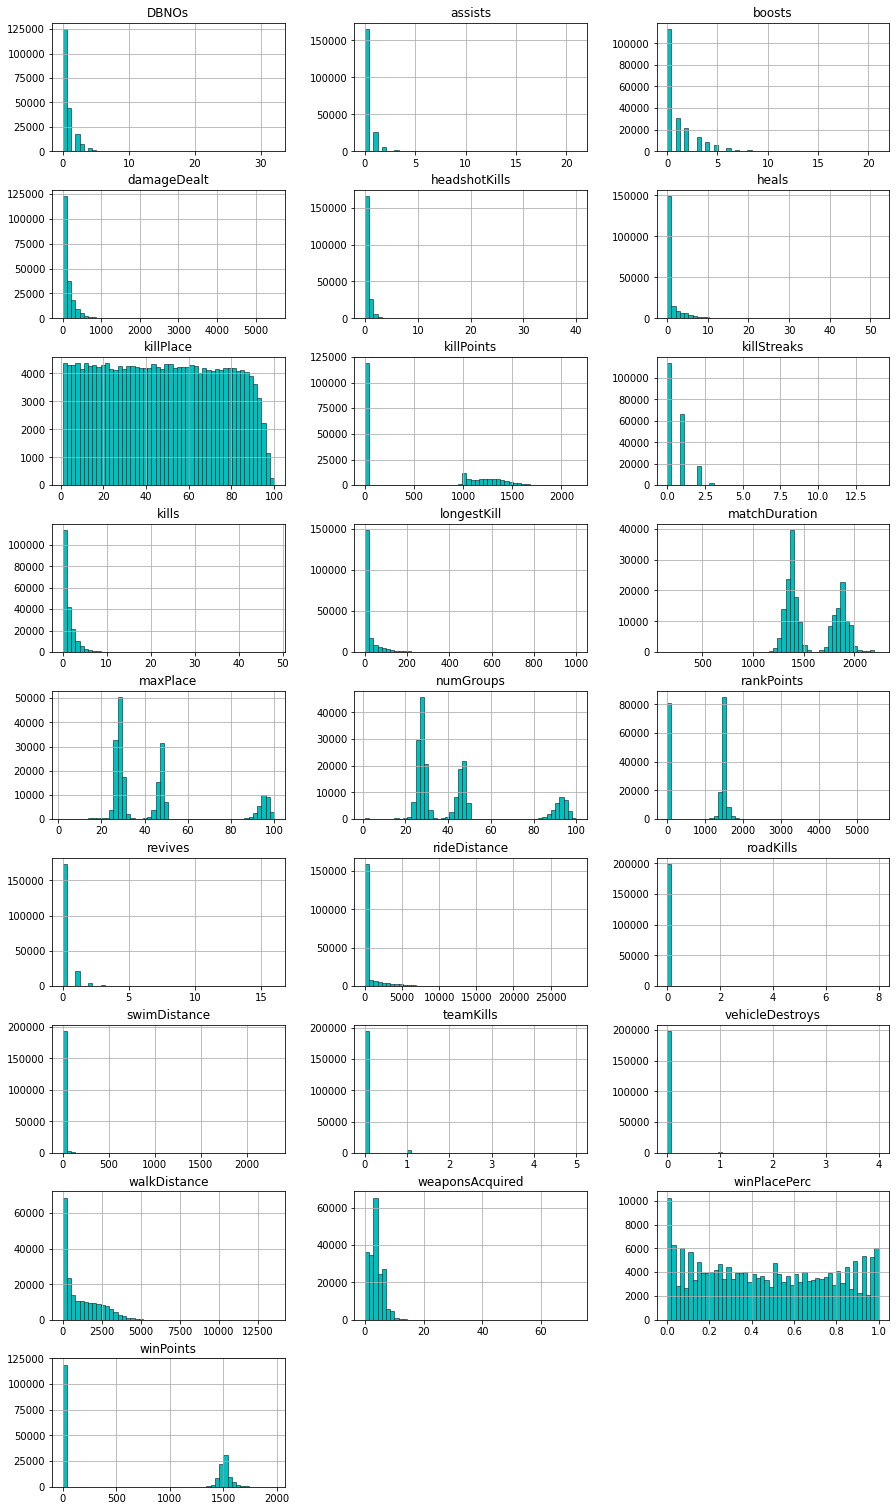

In [ ]:
distribution = df.hist(bins = 50, figsize = (15,30),layout = (10,3),edgecolor = 'black', linewidth = 0.5, color = 'c')
plt.show()

##히트맵

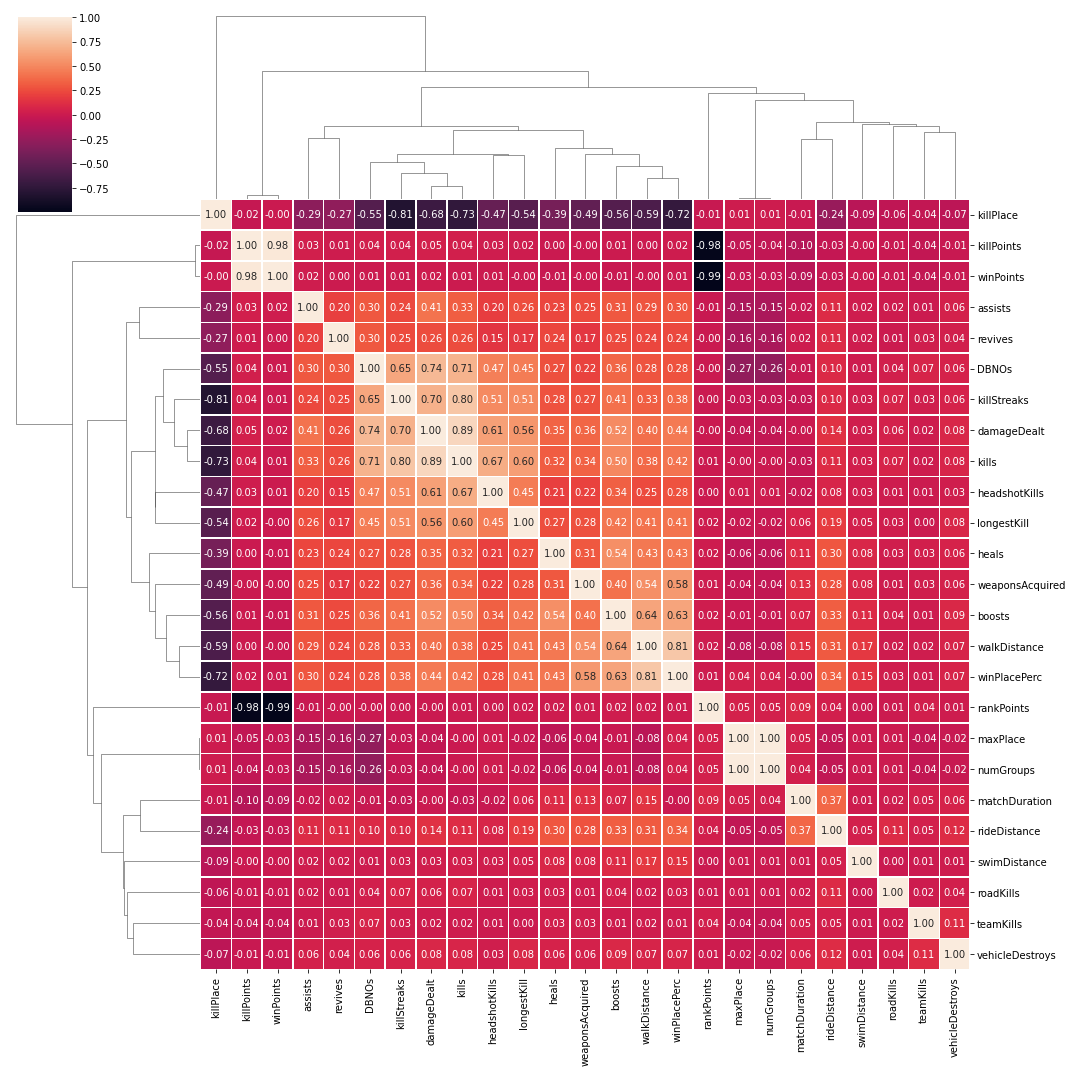

In [ ]:
# corr
ax = sns.clustermap(df.corr(), annot=True, linewidths=.6, fmt= '.2f', figsize=(15, 15))
plt.show()

In [ ]:
df.corr()['winPlacePerc']

assists            0.298367
boosts             0.634621
damageDealt        0.440500
DBNOs              0.277844
headshotKills      0.277627
heals              0.429090
killPlace         -0.719224
killPoints         0.015084
kills              0.418877
killStreaks        0.376309
longestKill        0.409622
matchDuration     -0.003155
maxPlace           0.042623
numGroups          0.044903
rankPoints         0.011136
revives            0.239053
rideDistance       0.343114
roadKills          0.034204
swimDistance       0.148829
teamKills          0.013053
vehicleDestroys    0.071971
walkDistance       0.810995
weaponsAcquired    0.582605
winPoints          0.009712
winPlacePerc       1.000000
Name: winPlacePerc, dtype: float64

## 상세 확인

In [ ]:
def visualize(col_name):
    '''
    Function for visualization
    '''
    title_name = col_name[0].upper() + col_name[1:]
    tmp = df[col_name].value_counts().sort_values(ascending=False)
    
    plt.figure(figsize=(10,5))
    plt.bar(tmp.index,np.log(tmp.values))
    plt.xlabel(title_name)
    plt.ylabel('log Count')
    plt.title(title_name + ' Histogram')
    plt.show()

    print('Min value of ' + title_name + ' is: ',min(tmp.index))
    print('Max value of ' + title_name + ' is: ',max(tmp.index))

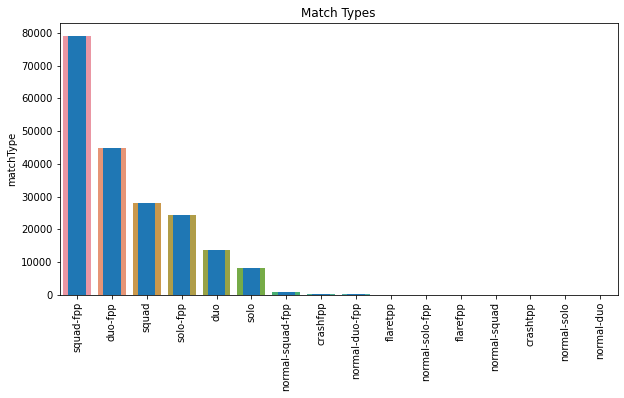

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x = df['matchType'].unique(),
            y = df['matchType'].value_counts()).set_title('Match Types')
df['matchType'].value_counts().plot.bar();

headshots = df[df['headshotKills']>0]
plt.figure(figsize=(15,5))
sns.countplot(headshots['headshotKills'].sort_values())
print("Maximum number of headshots that the player scored: " + str(df["headshotKills"].max()))

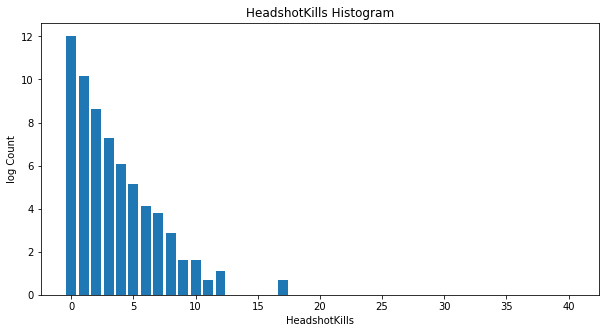

Min value of HeadshotKills is:  0
Max value of HeadshotKills is:  40


In [ ]:
visualize('headshotKills')

plt.figure(figsize=(15,5))
ax = sns.boxplot(x="killStreaks",y="kills", data = df)
ax.set_title("Number of kill streaks vs. Number of Kills")
plt.show()

In [ ]:
walk0 = df["walkDistance"] == 0
ride0 = df["rideDistance"] == 0
swim0 = df["swimDistance"] == 0
print("{} of players didn't walk at all, {} players didn't drive and {} didn't swim." .format(walk0.sum(),ride0.sum(),swim0.sum()))

print("Average longest kill distance a player achieve is {:.1f}m, 95% of them not more than {:.1f}m and a maximum distance is {:.1f}m." .format(df['longestKill'].mean(),df['longestKill'].quantile(0.95),df['longestKill'].max()))

print("Average longest kill distance a player achieve is {:.1f}m, 95% of them not more than {:.1f}m and a maximum distance is {:.1f}m." .format(df['longestKill'].mean(),df['longestKill'].quantile(0.95),df['longestKill'].max()))


4416 of players didn't walk at all, 148929 players didn't drive and 187004 didn't swim.
Average longest kill distance a player achieve is 22.9m, 95% of them not more than 125.9m and a maximum distance is 999.9m.
Average longest kill distance a player achieve is 22.9m, 95% of them not more than 125.9m and a maximum distance is 999.9m.


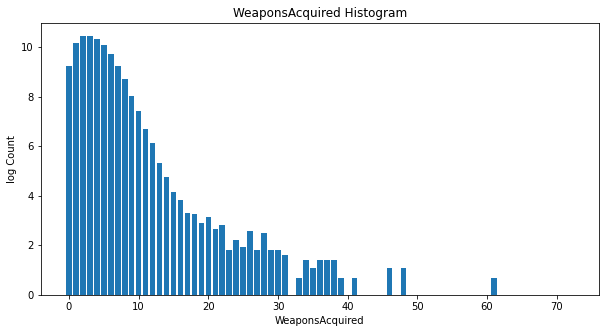

Min value of WeaponsAcquired is:  0
Max value of WeaponsAcquired is:  72
Average number of acquired weapons is 3.672, minimum is 0 and the maximum 72, 99% of players acquired less than weapons 10.0.


In [ ]:
#df.hist('weaponsAcquired', figsize = (15,5), range=(0, 20),align="left", rwidth=0.9)
visualize('weaponsAcquired')
plt.show()

print("Average number of acquired weapons is {:.3f}, minimum is {} and the maximum {}, 99% of players acquired less than weapons {}." 
      .format(df["weaponsAcquired"].mean(), df["weaponsAcquired"].min(), df["weaponsAcquired"].max(), df["weaponsAcquired"].quantile(0.99)))

### 임의의 Id를 기준으로 함께 플레이한 맴버를 시각화 해보는것. 
group_tmp = df[df['matchId']=='6680c7c3d17d48']['groupId'].value_counts().sort_values(ascending=False)



plt.figure()
plt.bar(group_tmp.index,group_tmp.values)
plt.xlabel('GroupId')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Number of Group Members in One Match')
plt.show()

print('Min number of group members is: ',min(group_tmp.values))
print('Max number of group members is: ',max(group_tmp.values))

+ 위의 그래프를 해석하자만, 솔로경기부터 이베트 매치까지 다양하게 플레이 한 것을 알 수 있다. 
+ 4이하는 일반적으로 노멀 또는 랭크게임을 돌린것이다. 
+ 6인 또는 11인 스쿼드는 이벤트매치 또는 사용자정의 매치를 돌린것으로 파악할 수 있다. 

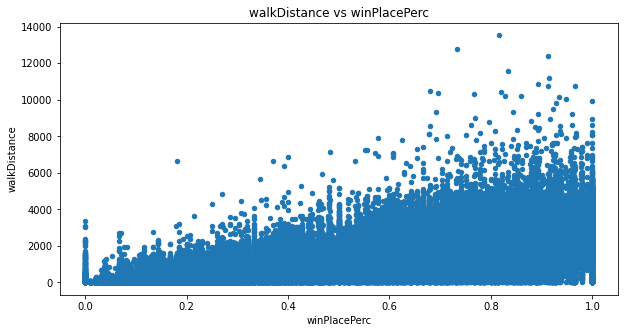

In [ ]:
df.plot(x="winPlacePerc", y="walkDistance", kind="scatter", figsize=(10,5), title='walkDistance vs winPlacePerc')

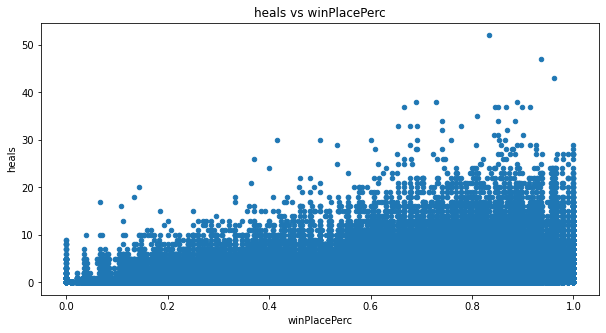

In [ ]:
df.plot(x="winPlacePerc", y="heals", kind="scatter", figsize=(10,5), title='heals vs winPlacePerc')

(-0.5, 17.5, 0.0, 1.0)

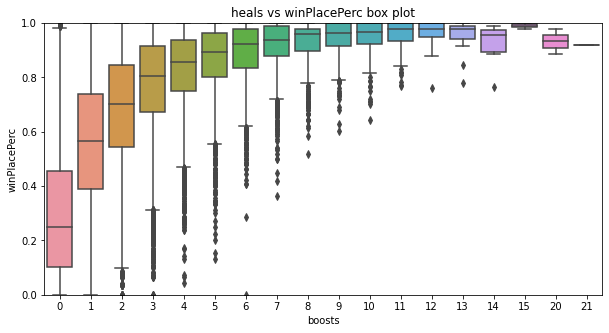

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='boosts', y="winPlacePerc", data=df)
plt.title('heals vs winPlacePerc box plot')
fig.axis(ymin=0, ymax=1)

Average number of kills: 2.6
Minimum: 0
The best: 42
99.9% of players within: 18.0 kills.


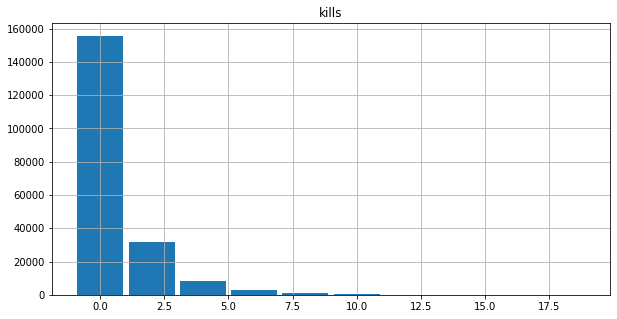

In [ ]:
# Top 10% Kill 분포
top10 = df[df["winPlacePerc"]>0.9]
print("Average number of kills: {:.1f}\nMinimum: {}\nThe best: {}\n99.9% of players within: {} kills." 
      .format(top10["kills"].mean(), top10["kills"].min(), top10["kills"].max(),top10["kills"].quantile(0.999)))

df.hist('kills', figsize = (10,5),range=(0, 20), align="left", rwidth=0.9)
plt.show()

###Groupby: MatchId, GroupId
* 팀 베이스 게임 모드는 팀에서 잘하는 사람이 하나만 있어도 팀 능력치가 크게 올라가기 때문에 groupId로 묶어서 봐야한다.

In [ ]:
df_group = df[:100000].groupby(['matchId', 'groupId'])
df_group.agg(['mean','max'])

assists     boosts  ... winPoints winPlacePerc        
                                 mean max   mean  ...       max         mean     max
matchId        groupId                            ...                               
0000a43bce5eec 4d1bbbc19b9084     1.0   1    3.0  ...      1480       1.0000  1.0000
               7bd08592bb25e2     0.0   0    1.0  ...      1502       0.6667  0.6667
               909fe185a8cdec     0.0   0    0.0  ...      1499       0.1852  0.1852
0000eb01ea6cdd 338a69335655a6     0.0   0    1.0  ...         0       0.5926  0.5926
               e63cccd7a15254     1.0   1    5.0  ...         0       1.0000  1.0000
...                               ...  ..    ...  ...       ...          ...     ...
fffe562611d981 5f74b1e18d8c96     0.0   0    0.0  ...      1482       0.3200  0.3200
fffe721f841f85 c5ba82f359b0d8     0.0   0    0.0  ...      1568       0.6667  0.6667
fffe92232706aa 14fdb6c222eff7     1.0   1    0.0  ...         0       0.1071  0.1071
               1958cde581220c     1.0   1    2.0  ...         0       0.8571  0.8571
               7b02f39a100956     0.0   0    1.0  ...         0       0.7500  0.7500

[97543 rows x 50 columns]

## 이슈: Hack User
이동 거리가 50미터 아래인데 킬수가 5 이상  
rating 1500 기준 <- 이걸 빼고 가장낮은 값을 0 으로   
거리 데이터 는 도메인 지식으로  
피처 를 범주화 한 후 각 범주에 대해 점수를 부여해서 새로운 컬럼을 만들 수 있다.  
 ((X['kills'] > 0) & (X['total_distance'] == 0)) 얘넨 잠수하는 애들. 어떻게 처리?


In [ ]:
suspects = df.query('winPlacePerc ==1 & walkDistance < 200')
suspects.shape

(111, 29)

In [ ]:
####이번 커널에서는 아웃라이어 삭제X
def remove_outliers(X):
    outliers = (X['walkDistance'] > 10000) | (X['rideDistance'] > 15000) | (X['swimDistance'] > 1000)
    outliers = outliers | (X['kills'] > 30) | (X['longestKill'] > 800)
    outliers = outliers | (X['kills'] > 2) & (X['winPlacePerc'] == 1) & ((X['walkDistance']+X['rideDistance']) < 200) #좀비핵
    X = X.loc[~outliers]
    return X

def get_outliers(X):
    outliers = (X['walkDistance'] > 10000) | (X['rideDistance'] > 15000) | (X['swimDistance'] > 1000)
    outliers = outliers | (X['kills'] > 30) | (X['longestKill'] > 800)
    outliers = outliers | (X['kills'] > 2) & (X['winPlacePerc'] == 1) & ((X['walkDistance']+X['rideDistance']) < 200) #좀비핵
    outlier_data = X.loc[outliers]
    return outlier_data

In [ ]:
df_outliers = get_outliers(df) # 핵 의심 추출

In [ ]:
df_outliers.shape

(85, 29)

distribution = df_outliers.hist(bins = 60, figsize = (20,30),layout = (9,3),edgecolor = 'black', linewidth = 1.0, color = 'c')
plt.show()

# Preprocessing

In [ ]:
df.shape

(200000, 29)

In [ ]:
test_origin.shape

(1934174, 28)

In [ ]:
df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [ ]:
# 비정상 매치 데이터 확인
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


In [ ]:
# 비정상 매치 데이터 제거
df.drop(df[df['winPlacePerc'].isnull()].index, inplace=True)

In [ ]:
# Plot custom function
def show_countplot(df, column):
    plt.figure(figsize=(15,5))
    sns.countplot(data=df, x=column).set_title(column)
    plt.show()
    
def show_distplot(df, column):
    plt.figure(figsize=(15, 5))
    sns.distplot(df[column], bins=50)
    plt.show()

In [ ]:
df['matchType'].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

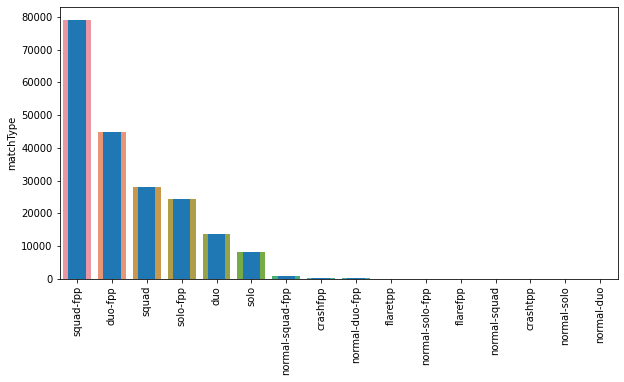

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x = df['matchType'].unique(),
            y = df['matchType'].value_counts())
df['matchType'].value_counts().plot.bar()

##추가: 파생변수
속도 관련한 변수도 추가 가능


* 지도 크기에 따라 Total_distance 에 가중치를 준다.  
참고: [Map comparision](https://colab.research.google.com/drive/1MEuhEOa9JWx5ulosOeMy2hvbnjO38c7d#scrollTo=r7CpX4DBDCDp&line=1&uniqifier=1)

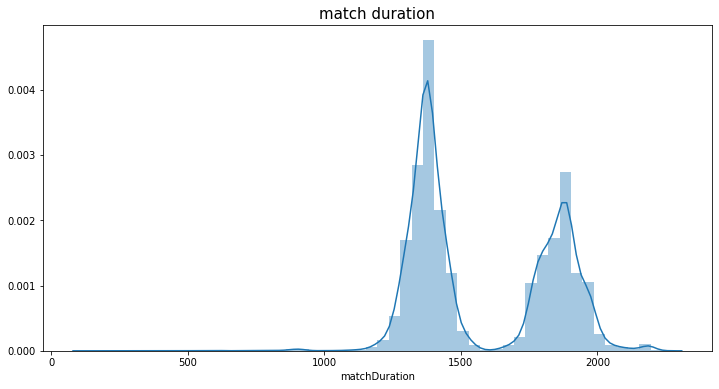

In [ ]:
# matchDuration으로 Map 나눌 수 있을 거 같음
plt.figure(figsize=(12,6))
plt.title("match duration",fontsize=15)
sns.distplot(df['matchDuration'])
plt.show()

df_origin[(df_origin['matchDuration']>1500) & (df_origin['matchDuration'] < 1700)]['matchDuration'].value_counts()

In [ ]:
def add_cols(X):
    X['total_distance'] = X['walkDistance']+ X['rideDistance']
    #X['kill_assist'] = X['kills'] + X['assists'] * 0.7
    X['headshot_ratio'] = X['headshotKills'] / X['kills'] 
    X['headshot_ratio'].fillna(float(0), inplace = True)
    X.loc[X['rankPoints'] == -1, 'rankPoints'] = 0
    X['mmr'] = X['rankPoints'] + X['winPoints'] #rankPoints + winPoints
    X.drop(['rankPoints','winPoints'], axis = 1, inplace = True)
    X.loc[X['matchDuration'] <= 1610, 'map'] = 0  # sanhok
    X.loc[X['matchDuration'] > 1610, 'map'] = 1 # erangel

    return X

def adjust_distance(X):
  X.loc[X['map'] ==0, 'total_distance'] = X['total_distance']*0.25

  return X

### Plot 그려보기

In [ ]:
df = df_origin.copy()

In [ ]:
df = adjust_distance(add_cols(df))

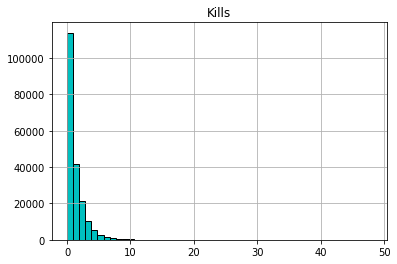

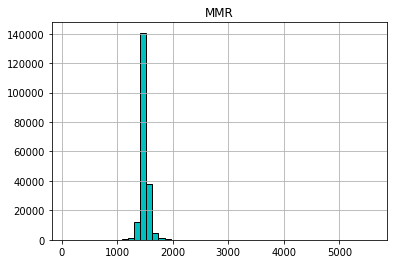

kills > 4 & (headshotKills / kills) >= 0.9 
 count: 23  winPlacePerc: 0.835


In [ ]:
#plt.figure(figsize=(15,5))
#sns.countplot(data = df, x = 'kills').set_title('kills')
#plt.show()

#cols = ['kills','assists','kill_assist']
#distribution = df[cols].hist(bins = 30, figsize = (15,30),layout = (8,4),edgecolor = 'black', linewidth = 1.0, color = 'c')
#plt.show()

plt.title('Kills')
df['kills'].hist(bins = 50, figsize = (6,4), edgecolor = 'black', linewidth = 1.0, color = 'c')
plt.show()

plt.title('MMR')
df['mmr'].hist(bins = 50, figsize = (6,4), edgecolor = 'black', linewidth = 1.0, color = 'c')
plt.show()

sq = 'kills > 4 & (headshotKills / kills) >= 0.9'
sub = df.query(sq)
print(sq, '\n count:', len(sub), ' winPlacePerc:', round(sub['winPlacePerc'].mean(),3))

##삭제: 애매한 columns
['matchDuration', 'numGroups','rideDistance', 'swimDistance',
           'vehicleDestroys','walkDistance','DBNOs','revives',
           'teamKills','roadKills', 'kills', 'assists', 'headshotKills']


**[Carlo](https://www.kaggle.com/carlolepelaars/pubg-data-exploration-rf-funny-gifs) 에 의하면 ID는 삭제하였지만 그룹, 매치 ID는 삭제하지 않고 카테고리로 코드 변환을 하여 살려두었다.  
본 커널은 삭제하여 진행해본다.

In [ ]:
def drop_cols(X):
    to_drop = ['vehicleDestroys','DBNOs','revives',
              'teamKills','roadKills',
              #'matchDuration', # map 종류를 나누는 곳에 사용할 수 있음.
              'headshotKills', # headshot ratio 에서 사용
              'rideDistance', 'swimDistance', 'walkDistance', # total_distance에 이미 사용한 features
              'numGroups' # 매우 부정확한 경우가 많음. 대신할 수 있는 feature가 있음: 'maxPlace'
              ]
    # Credit to Jaeyoeb
    int_columns = ['assists', 'boosts', 'DBNos', 'headshotKills', 'heals', 'killPlace', 'killPoints', \
                      'kills', 'killStreaks', 'matchDuration', 'maxPlace', 'maxGroups', 'rankPoints', 'revives', 'roadKills', \
                      'teamKills',' vehicleDestroys', 'weaponsAcquired', 'winPoints']

    float_columns = ['damageDealt', 'longestKill', 'rideDistance', 'swimDistance', 'walkDistance']

    non_object_columns = int_columns + float_columns

    id_columns = ['Id', 'groupId', 'matchId']

    target = ['winPlacePerc']

    X.drop(to_drop, axis = 1, inplace=True)

    return X

In [ ]:
def process_col(X):
  drop_cols(adjust_distance(add_cols(X)))
  
  return X

In [ ]:
df = df_origin.copy()

In [ ]:
process_col(df)

,Id,groupId,matchId,assists,boosts,damageDealt,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,weaponsAcquired,winPlacePerc,total_distance,headshot_ratio,mmr,map
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,60,1241,0,0,0.00,1306,squad-fpp,28,1,0.4444,61.2000,0.000000,1466,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,57,0,0,0,0.00,1777,squad-fpp,26,5,0.6400,1434.0045,0.000000,1484,1.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,47,0,0,0,0.00,1318,duo,50,2,0.7755,40.4500,0.000000,1491,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,75,0,0,0,0.00,1436,squad-fpp,31,3,0.1667,50.6750,0.000000,1408,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,45,0,1,1,58.53,1424,solo-fpp,97,2,0.1875,12.4375,0.000000,1560,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,8a03aca8bca167,71ff27619423a3,40c91483da5bb9,0,0,0.00,0,68,0,0,0,0.00,1815,squad-fpp,26,7,0.4000,1531.0000,0.000000,1500,1.0
199996,982176c1463624,d334f56b3a33be,cfc5059075d4ff,0,0,34.36,0,82,0,0,0,0.00,2161,solo-fpp,91,1,0.0778,11.6800,0.000000,1494,1.0
199997,7f55e229133735,b4c4099f227e4d,de2f69ee694142,0,2,327.90,0,5,0,3,1,216.80,1727,solo-fpp,93,8,0.9891,5547.0000,0.333333,1608,1.0
199998,bb6519ba90106c,a8712a3317b739,455a0249beebf8,0,2,311.50,1,10,0,2,1,58.28,1860,squad,28,5,0.7407,4823.0000,0.500000,1515,1.0


In [ ]:
df

,Id,groupId,matchId,assists,boosts,damageDealt,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,weaponsAcquired,winPlacePerc,total_distance,headshot_ratio,mmr,map
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,60,1241,0,0,0.00,1306,squad-fpp,28,1,0.4444,61.2000,0.000000,1466,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,57,0,0,0,0.00,1777,squad-fpp,26,5,0.6400,1434.0045,0.000000,1484,1.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,47,0,0,0,0.00,1318,duo,50,2,0.7755,40.4500,0.000000,1491,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,75,0,0,0,0.00,1436,squad-fpp,31,3,0.1667,50.6750,0.000000,1408,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,45,0,1,1,58.53,1424,solo-fpp,97,2,0.1875,12.4375,0.000000,1560,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,8a03aca8bca167,71ff27619423a3,40c91483da5bb9,0,0,0.00,0,68,0,0,0,0.00,1815,squad-fpp,26,7,0.4000,1531.0000,0.000000,1500,1.0
199996,982176c1463624,d334f56b3a33be,cfc5059075d4ff,0,0,34.36,0,82,0,0,0,0.00,2161,solo-fpp,91,1,0.0778,11.6800,0.000000,1494,1.0
199997,7f55e229133735,b4c4099f227e4d,de2f69ee694142,0,2,327.90,0,5,0,3,1,216.80,1727,solo-fpp,93,8,0.9891,5547.0000,0.333333,1608,1.0
199998,bb6519ba90106c,a8712a3317b739,455a0249beebf8,0,2,311.50,1,10,0,2,1,58.28,1860,squad,28,5,0.7407,4823.0000,0.500000,1515,1.0


## 분리: matchId, groupId

In [ ]:
df = df_origin.copy()

In [ ]:
print(df.shape)
print(test_origin.shape)

(200000, 29)
(1934174, 28)


In [ ]:
test_origin.shape

(1934174, 28)

In [ ]:
df_pre = process_col(df)
test = process_col(test_origin)
print(df_pre.shape)
print(test.shape)

(200000, 21)
(1934174, 20)


In [ ]:
def feature_engineering(is_train=True, debug=True):
    test_id = None
    if is_train: 
        print("processing train set")
        if debug == True:
            df = df_pre
            #df = pd.read_csv('train_V2.csv', nrows=100000)
        else:
            df = df_pre
            #df = pd.read_csv('train_V2.csv')           

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test set")
        df = test
        test_id = df.Id
    
    #df = reduce_mem_usage(df)
    
    print("remove some columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")  
    
    y = None
    
    
    if is_train: 
        print("get target")
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]
    
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])

    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = df_out
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names, test_id

In [ ]:
X, y, train_columns, _ = feature_engineering(True,False)
test, _, _ , test_id = feature_engineering(False,True)
#X_train, y_train, train_columns, _ = feature_engineering(True,False)

processing train set
remove some columns
get target
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature
processing test set
remove some columns
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [ ]:
#df.describe().T

## matchType 별 분포

df_st = df[df['matchType'] == 'solo']
df_sf = df[df['matchType'] == 'solo-fpp']
df_dt = df[df['matchType'] == 'duo']
df_df = df[df['matchType'] == 'duo-fpp']
df_sqt = df[df['matchType'] == 'squad']
df_sqf = df[df['matchType'] == 'squad-fpp']

df_st.describe([0.5, .75, .90,.98, .99],include=np.number).drop('count')

df.groupby('matchType').agg('max')

desc0 = df.groupby('matchType').describe(percentiles = [0.5, .75, .90,.98, .99],include=np.number)
desc0.T.drop(index = 'count', level =1)

desc0[['walkDistance', 'rideDistance','swimDistance','total_distance']].T.drop(index = 'count', level =1)

df.hist(bins = 30, figsize = (15,30),layout = (8,4),edgecolor = 'black', linewidth = 1.0, color = 'c');

##추출: df_others 

df_others 대상 columns  

other_modes = ['normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp','normal-solo']

df_others = df[df['matchType'].isin(other_modes)]

df_others['matchType'].unique()

## 삭제: df - df_others

other 모드들 삭제
df.drop(df[df['matchType'].isin(other_modes)].index, inplace = True)


for mode in modes:
  df.drop(df[df['matchType'] == mode].index, inplace = True)

df['matchType'].unique()

plt.figure(figsize=(10,5))
sns.barplot(x = df['matchType'].unique(),
            y = df['matchType'].value_counts())
df['matchType'].value_counts().plot.bar()

plt.figure(figsize=(10,5))
sns.barplot(x = df_others['matchType'].unique(),
            y = df_others['matchType'].value_counts())
df_others['matchType'].value_counts().plot.bar()

In [ ]:
####MY display 설정
pd.set_option('display.max_rows', 10000)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.3f}'.format

# Modeling

One hot encoding

from sklearn.preprocessing import OneHotEncoder

onehot = pd.get_dummies(df['matchType'])
df = pd.concat([df, onehot], axis = 1)
df.head()

df.filter(regex='matchType').head()

Dataframe split 2차

원본  

df_st = df[df['matchType'] == 'solo']
df_sf = df[df['matchType'] == 'solo-fpp']
df_dt = df[df['matchType'] == 'duo']
df_df = df[df['matchType'] == 'duo-fpp']
df_sqt = df[df['matchType'] == 'squad']
df_sqf = df[df['matchType'] == 'squad-fpp']

df_st = df[df['matchType'] == 'solo'][:20000]
df_sf = df[df['matchType'] == 'solo-fpp'][:20000]
df_dt = df[df['matchType'] == 'duo'][:20000]
df_df = df[df['matchType'] == 'duo-fpp'][:20000]
df_sqt = df[df['matchType'] == 'squad'][:20000]
df_sqf = df[df['matchType'] == 'squad-fpp'][:20000]

df.drop(['matchType'], axis = 1, inplace = True)

df_st.drop(['matchType'], axis = 1, inplace = True)
df_sf.drop(['matchType'], axis = 1, inplace = True)
df_dt.drop(['matchType'], axis = 1, inplace = True)
df_df.drop(['matchType'], axis = 1, inplace = True)
df_sqt.drop(['matchType'], axis = 1, inplace = True)
df_sqf.drop(['matchType'], axis = 1, inplace = True)
df_others.drop(['matchType'], axis = 1, inplace = True)

분포 확인
df_sqf.describe().T

Train Test Split
이거 좀 loop로 안되나?!!!!
빡쳐서 일단 4개 세트만 해본다

In [ ]:
X_st, y_st = df_st.drop(['winPlacePerc'], axis =1), df_st.winPlacePerc
X_sf, y_sf = df_sf.drop(['winPlacePerc'], axis =1), df_sf.winPlacePerc
X_sqt, y_sqt = df_sqt.drop(['winPlacePerc'], axis =1), df_sqt.winPlacePerc
X_sqf, y_sqf = df_sqf.drop(['winPlacePerc'], axis =1), df_sqf.winPlacePerc

In [ ]:
st_X_train, st_X_test, st_y_train, st_y_test = train_test_split(X_st,y_st, test_size=0.2, random_state=0)
sf_X_train, sf_X_test, sf_y_train, sf_y_test = train_test_split(X_sf,y_sf, test_size=0.2, random_state=0)
sqt_X_train, sqt_X_test, sqt_y_train, sqt_y_test = train_test_split(X_sqt,y_sqt, test_size=0.2, random_state=0)
sqf_X_train, sqf_X_test, sqf_y_train, sqf_y_test = train_test_split(X_sqf,y_sqf, test_size=0.2, random_state=0)

print(st_X_train.shape, st_X_test.shape, st_y_train.shape, st_y_test.shape)
print(sf_X_train.shape, sf_X_test.shape, sf_y_train.shape, sf_y_test.shape)
print(sqt_X_train.shape, sqt_X_test.shape, sqt_y_train.shape, sqt_y_test.shape)
print(sqf_X_train.shape, sqf_X_test.shape, sqf_y_train.shape, sqf_y_test.shape)

#### Feature Scaling & Split

from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#X, y = df.drop(['winPlacePerc'], axis =1), df.winPlacePerc
def Scaler(x):
  Columns = x.columns
  x = MinMaxScaler(feature_range=(-1, 1)).fit_transform(x)
  x = pd.DataFrame(data = x, columns= Columns)

  return x
#X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.2, random_state=0)

In [ ]:
X1 = Scaler(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.2, random_state = 1234)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(152336, 114) (152336,)
(38084, 114) (38084,)


In [ ]:
X_train

,assists_mean,boosts_mean,damageDealt_mean,heals_mean,killPlace_mean,killPoints_mean,kills_mean,killStreaks_mean,longestKill_mean,matchDuration_mean,maxPlace_mean,weaponsAcquired_mean,total_distance_mean,headshot_ratio_mean,mmr_mean,map_mean,assists_mean_rank,boosts_mean_rank,damageDealt_mean_rank,heals_mean_rank,killPlace_mean_rank,killPoints_mean_rank,kills_mean_rank,killStreaks_mean_rank,longestKill_mean_rank,matchDuration_mean_rank,maxPlace_mean_rank,weaponsAcquired_mean_rank,total_distance_mean_rank,headshot_ratio_mean_rank,mmr_mean_rank,map_mean_rank,assists_max,boosts_max,damageDealt_max,heals_max,killPlace_max,killPoints_max,kills_max,killStreaks_max,...,maxPlace_min,weaponsAcquired_min,total_distance_min,headshot_ratio_min,mmr_min,map_min,assists_min_rank,boosts_min_rank,damageDealt_min_rank,heals_min_rank,killPlace_min_rank,killPoints_min_rank,kills_min_rank,killStreaks_min_rank,longestKill_min_rank,matchDuration_min_rank,maxPlace_min_rank,weaponsAcquired_min_rank,total_distance_min_rank,headshot_ratio_min_rank,mmr_min_rank,map_min_rank,group_size,assists,boosts,damageDealt,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,weaponsAcquired,total_distance,headshot_ratio,mmr,map,match_size
109197,-1.000,-1.000,-1.000,-1.000,0.697,-0.679,-1.000,-1.000,-1.000,0.147,-0.143,-1.000,-1.000,-1.000,-0.778,-1.000,-1.000,-1.000,-1.000,-1.000,0.793,-0.149,-1.000,-1.000,-1.000,-0.656,0.084,-1.000,-1.000,-1.000,-0.999,-1.000,-1.000,-1.000,-1.000,-1.000,0.697,-0.680,-1.000,-1.000,...,-0.143,-1.000,-1.000,-1.000,-0.778,-1.000,-0.286,-0.688,-0.760,-0.528,1.000,-0.896,-0.688,-0.688,-0.688,-0.896,-0.896,-0.896,-0.896,-0.350,-0.896,-0.896,-1.000,-0.976,-0.841,-0.953,-0.939,-0.237,0.034,-0.958,-0.708,-0.962,0.147,-0.143,-0.898,-0.944,-0.667,-0.494,-1.000,0.000
39892,-1.000,-0.524,-0.944,-0.692,-0.414,-0.065,-1.000,-1.000,-1.000,0.673,-0.408,-0.833,-0.794,-1.000,-0.489,1.000,-1.000,0.872,0.301,0.904,-0.376,-0.079,-1.000,-1.000,-1.000,0.734,0.017,0.679,0.668,-1.000,0.072,1.000,-1.000,-0.524,-0.944,-0.692,-0.414,-0.071,-1.000,-1.000,...,-0.408,-0.833,-0.794,-1.000,-0.489,1.000,0.429,1.000,1.000,1.000,-0.083,0.458,0.438,0.438,0.438,-0.083,-0.083,-0.083,-0.083,0.400,0.458,-0.083,-1.000,-1.000,-0.364,-0.968,-0.758,-0.404,0.030,-1.000,-1.000,-1.000,0.673,-0.408,-0.787,-0.371,-1.000,-0.460,1.000,-0.857
120249,-1.000,-1.000,-0.970,-1.000,0.636,0.076,-1.000,-1.000,-1.000,0.749,-0.449,-1.000,-0.995,-1.000,-0.482,1.000,-1.000,-1.000,-0.182,-1.000,0.732,0.248,-1.000,-1.000,-1.000,0.932,-0.240,-1.000,-0.452,-1.000,0.474,1.000,-1.000,-1.000,-0.970,-1.000,0.636,0.070,-1.000,-1.000,...,-0.449,-1.000,-0.995,-1.000,-0.482,1.000,0.143,-0.125,-0.083,-0.389,1.000,0.458,-0.125,-0.125,-0.125,-0.625,-0.625,-0.625,-0.625,-0.200,0.458,-0.625,-1.000,-1.000,-0.955,-0.945,-0.970,0.116,0.243,-0.990,-0.917,-0.987,0.749,-0.449,-0.893,-0.583,-0.500,-0.447,1.000,-0.571
104403,-1.000,-0.714,-0.915,-0.923,-0.414,-1.000,-0.958,-0.857,-0.488,0.652,-0.429,-0.833,-0.620,-1.000,-0.488,1.000,-1.000,0.616,0.579,0.378,-0.376,-1.000,0.089,0.267,0.977,0.597,-0.068,0.679,0.851,-1.000,0.227,1.000,-1.000,-0.714,-0.915,-0.923,-0.414,-1.000,-0.958,-0.857,...,-0.429,-0.833,-0.620,-1.000,-0.488,1.000,-0.143,1.000,1.000,0.778,-0.300,0.133,0.100,0.100,1.000,-0.733,-0.733,1.000,1.000,-0.200,1.000,-0.733,-1.000,-0.981,-0.855,-0.953,-0.952,-0.135,-1.000,-0.958,-0.667,-0.780,0.652,-0.429,-0.921,-0.747,-0.800,-0.476,1.000,-0.429
130726,-1.000,-1.000,-0.902,-0.846,-0.899,-1.000,-0.833,-0.714,-0.749,0.643,-0.490,-0.917,-0.630,-0.500,-0.509,1.000,-1.000,-1.000,0.660,0.662,-0.892,-1.000,0.862,0.850,0.860,0.550,-0.732,-0.157,0.841,0.552,-0.731,1.000,-1.000,-1.000,-0.902,-0.846,-0.899,-1.000,-0.833,-0.714,...,-0.490,-0.917,-0.630,-0.500,-0.509,1.000,-0.143,-0.406,1.000,0.444,-0.625,0.187,1.000,1.000,1.000,-0.625,-0.625,-0.354,1.000,1.000,-0.083,-0.625,-1.000,-0.981,-0.745,-0.951,-0.685,-0.143,-1.000,-0.933,-0.733,-0.822,0.643,-0.490,-0.856,-0.467,-0.900,-0.443,1.000,-0.429
..

###Logistic Regression
LogisticRegression.proba 를 이용해 0~1 값 예측 가능할 것으로 예상

In [ ]:
#lr = LogisticRegression()

###Randomforest Regressor

rf_reg = RandomForestRegressor(n_estimators=15, random_state=0)

print(rf_reg)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)

accuracy = accuracy_score(y_test, rf_pred)
mae = mean_squared_error(y_test, rf_pred)
print('MAE:{0:.4f} '.format(mae))

params = {'n_estimators':[100,300,500],
    'max_depth' : [10, 15], 
    'min_samples_leaf' : [3, 7],
    #'min_samples_split' : [2, 6, 12, 16]
    }


start_time = time.time()

grid_cv = GridSearchCV(rf_reg , param_grid=params , cv=3, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

print("걸린 시간(초) :", time.time() - start_time)

best_dclf = grid_cv. best_estimator_
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 정확도 : {0:.4f}'.format(accuracy))

### LGBM Regressor

In [ ]:
params_full = {"objective" : ["regression"],
          'n_estimators': [100, 500, 2000], 
          "num_leaves" : [10, 15, 20, 30],
          "learning_rate" : [0.03, 0.05, 0.1],
          "bagging_fraction" : [0.7],
          "bagging_seed" : [0],
          "num_threads" : [2,4,8],
          "colsample_bytree" : [0.7],
          #"device" : "gpu"
          }

params = {'n_estimators': [200],
          'learning_rate' : [0.03],
          #'min_child_samples' : [1, 3, 5, 20],
          'num_leaves' : [10, 15, 20],
          "num_threads" : [4],
           'max_depth' : [10, 15, 20],
          "bagging_fraction" : [0.5, 0.7, 0.9],
          }

fit_params={"early_stopping_rounds": 50, 
            "eval_metric" : "mae", 
            "eval_set" : [[X_test, y_test]]
            }

In [ ]:
lgbm_reg = LGBMRegressor()
lgbm_reg.fit(X_train, y_train, eval_metric='mae', verbose = False,
             #eval_set=[(X_test, y_test)]) #eval_metric 기본값 rmse(회m귀), error(분류)
            )
             # eval_set:성능평가를 수행할 테스트 데이터 세트.
lgbm_pred = lgbm_reg.predict(X_test)

mae = mean_absolute_error(y_test,lgbm_pred)
#acc = accuracy_score(y_test,lgbm_pred)
print('LGBM MAE:{0:.4f}'.format(mae))

LGBM MAE:0.0627


In [ ]:
# GridSearchCV
start_time = time.time()

grid_cv = GridSearchCV(lgbm_reg, param_grid=params, cv=3 ,verbose= False, n_jobs = -1)
grid_cv.fit(X_train , y_train, **fit_params)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
print("LGBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

best_dclf = grid_cv.best_estimator_
predictions = best_dclf.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
#acc = accuracy_score(y_test,dpredictions)

print('테스트 세트에서의 LGBM MAE: {0:.4f}'.format(mae))

[1]	valid_0's l2: 0.0890414	valid_0's l1: 0.259948
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l2: 0.0847486	valid_0's l1: 0.253384
[3]	valid_0's l2: 0.0806764	valid_0's l1: 0.24697
[4]	valid_0's l2: 0.0768711	valid_0's l1: 0.240861
[5]	valid_0's l2: 0.0732578	valid_0's l1: 0.234877
[6]	valid_0's l2: 0.06988	valid_0's l1: 0.229162
[7]	valid_0's l2: 0.0667015	valid_0's l1: 0.223651
[8]	valid_0's l2: 0.0636617	valid_0's l1: 0.218232
[9]	valid_0's l2: 0.0608353	valid_0's l1: 0.213106
[10]	valid_0's l2: 0.0581412	valid_0's l1: 0.208083
[11]	valid_0's l2: 0.0555761	valid_0's l1: 0.203157
[12]	valid_0's l2: 0.0531642	valid_0's l1: 0.198428
[13]	valid_0's l2: 0.0509052	valid_0's l1: 0.193919
[14]	valid_0's l2: 0.0488037	valid_0's l1: 0.189624
[15]	valid_0's l2: 0.0467949	valid_0's l1: 0.185398
[16]	valid_0's l2: 0.0448823	valid_0's l1: 0.181306
[17]	valid_0's l2: 0.0431187	valid_0's l1: 0.177453
[18]	valid_0's l2: 0.0414086	valid_0's l1: 0.173619
[19]	valid_0's

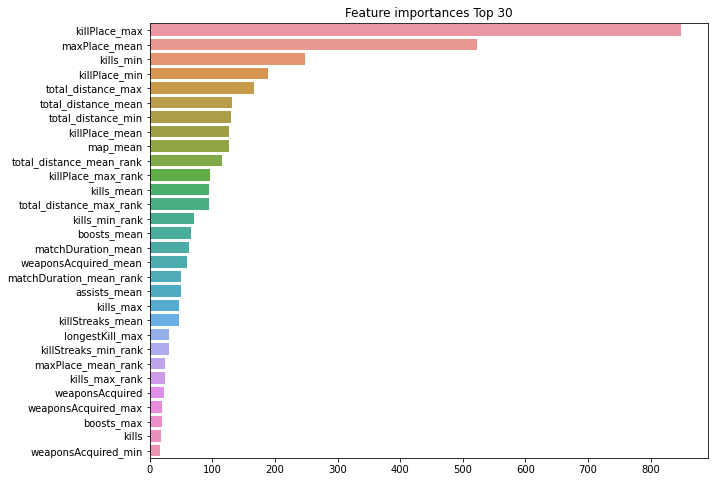

In [ ]:
from lightgbm import plot_importance 

ftr_importances_values = best_dclf.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:30]
plt.figure(figsize=(10,8))
plt.title('Feature importances Top 30')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

###DNN

In [ ]:
def Scaler_Q(x):
  QuantileTransformer().fit_transform(x)
  return x

In [ ]:
X2 = Scaler(X)

In [ ]:
X2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state = 1234)

In [ ]:
Optimizer = optimizers.Adam(lr=0.01, epsilon=1e-8, decay=1e-4, amsgrad=False)

In [ ]:
def create_model(X_train, y_train = None):
        model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, kernel_initializer='he_normal', activation = 'elu', input_shape = (X_train.shape[1],)),
        #tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation = 'elu'),
        #tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, kernel_initializer='he_normal', activation = 'elu'),
        #tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, kernel_initializer='he_normal', activation = 'elu'),
        #tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, kernel_initializer='normal', activation = 'sigmoid')
        ])
    
        model.compile(optimizer= 'Adam',
                      loss='mse',
                      metrics=['mae'])
    
        return model

In [ ]:
model = create_model(X_train)
model.summary()

In [ ]:
model.fit(X_train, y_train, 
          epochs=30,
          validation_split = 0.2,
          batch_size = 512,
          #callbacks = [cp_callback]
          )

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
NN_predictions = model.predict(X_test)

#Submission

test = test_origin.copy()
test = reduce_mem_usage(test)

###test 파일 내용 확인

test['matchType'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x = test['matchType'].unique(),
            y = test['matchType'].value_counts())
test['matchType'].value_counts().plot.bar()

test_id = test['Id']

### OHE

onehot_test = pd.get_dummies(test['matchType'])
test = pd.concat([test, onehot_test], axis = 1)
test.shape

###test 파일 col 변경

# test col 추가
add_cols(test)

# test col 삭제
#test.drop(to_drop, axis = 1, inplace = True)
test.drop(['Id', 'groupId', 'matchId', 'matchType'], axis = 1, inplace=True)
test.drop(to_drop, axis = 1, inplace = True)

test_columns = test.columns
test = MinMaxScaler(feature_range=(0, 1)).fit_transform(test)
test = pd.DataFrame(data = test, columns= test_columns)

print(X.shape)
print(test.shape)

### submission 만들기

#### df_sub = test DF 로 모델 돌린 후 pred 전체 합치기
print("Storing final submission to file...")
df_sub[["Id", "winPlacePerc"]].to_csv("lgbm_submission_4_adjusted.csv", index=False)
dir must be 'kaggle/working' to submission
print("Done.")

cd /kaggle/working/

In [ ]:
Scaler(test)

predictions = model.predict(test) # M/L
NN_predictions = model.predict(test) # D/L

In [ ]:
predictions = np.clip(a = predictions, a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test_id, 'winPlacePerc' : predictions})
 
# Create submission file
pred_df.to_csv("submission.csv", index=False)